# Introducción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y solicitó que se evalúe esa posibilidad.

- Objetivo 1: Encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.


- Objetivo 2: Predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?


- Objetivo 3: Predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.


- Objetivo 4: Proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Se implementará un algoritimo enmascaramiento u ofuscación de datos. Los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. 


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
import sklearn.preprocessing

import math

from scipy.spatial import distance

from sklearn.model_selection import train_test_split

from IPython.display import display

## Carga de datos

Cargamos los datos y verificamos

In [3]:
try:
    df = pd.read_csv('/datasets/insurance_us.csv')
except:
    df = pd.read_csv('insurance_us.csv')
    

In [4]:
df.head()

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Renombramos las columnas para que el código se vea más coherente con su estilo.

In [75]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [76]:
df.sample(5)

,gender,age,income,family_members,insurance_benefits
2070,0,47.0,43100.0,0,1
4078,0,40.0,55300.0,2,0
257,0,37.0,52500.0,3,0
3526,1,19.0,38600.0,1,0
1064,0,27.0,44400.0,2,0


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [78]:
# Cambiamos el tipo de dato a int de la variable 'age'.
df['age'] = df['age'].astype(int)

In [79]:
# compruebamos la conversión
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [80]:
# Realizamos una observación descriptiva de los datos.
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [81]:
df.columns

Index(['gender', 'age', 'income', 'family_members', 'insurance_benefits'], dtype='object')

<AxesSubplot:xlabel='gender'>

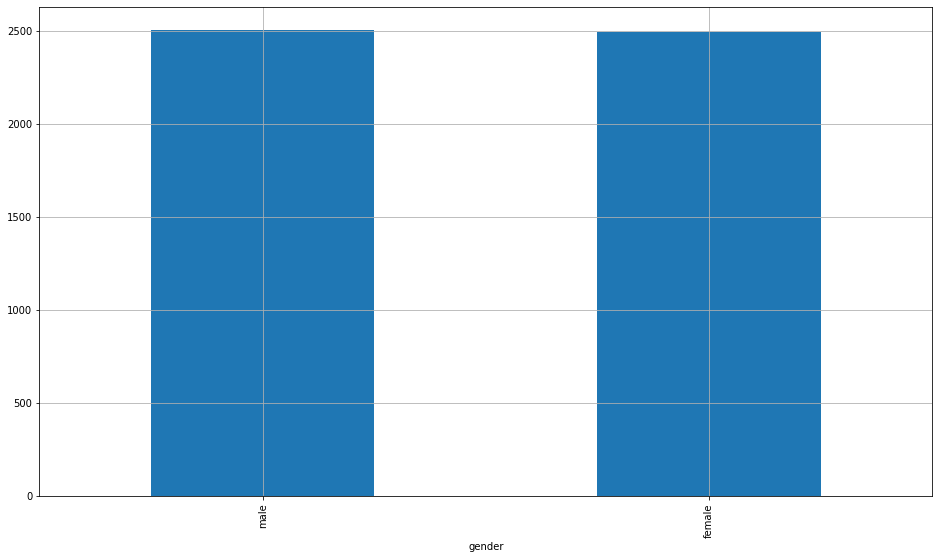

In [82]:
#Visualizamos la distribución de la variable género
df.pivot_table(columns= 'gender', aggfunc= 'count').rename(columns= {0:'male',1:'female'}).iloc[1].plot(kind= 'bar', grid= True, figsize= (16,9))

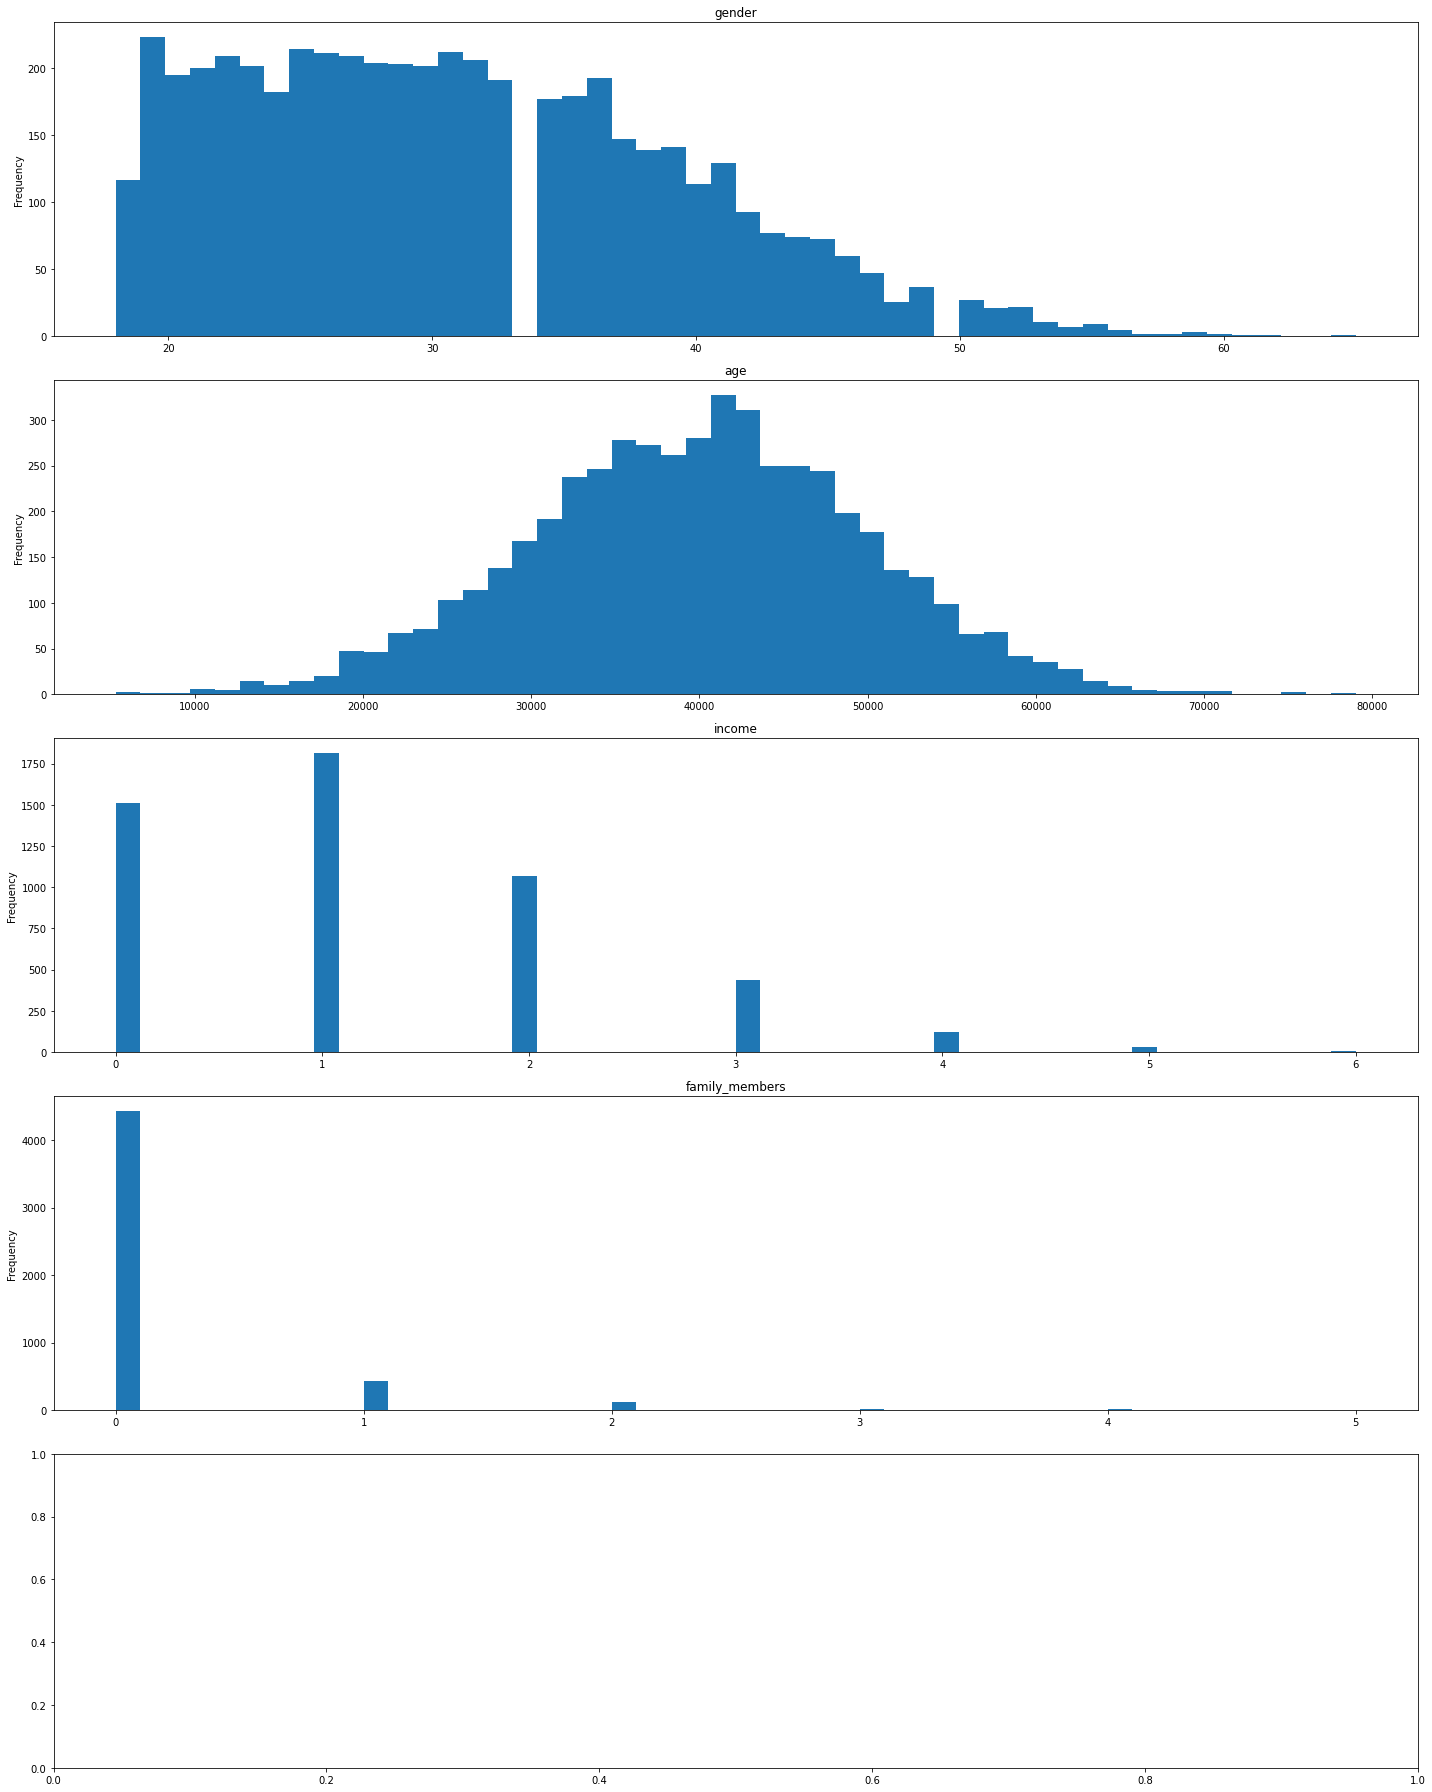

In [83]:
# Obervamos la distribución de las demás variables.

plt.rcParams["figure.figsize"] = [20, 25]
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(5,1)

for i in range(len(df.columns)-1):
    df[df.columns[i+1]].plot(kind= 'hist', bins=50, ax= axes[i], title= df.columns[i])
    

**Cocluciones:**

- La variable 'insurance_benefits' en su mayorí tiene valoeres 0.
- La mayor parte de la muestra observada tiene entre 20 y 40 años.
- La mayoría son individuos úmicos o tienen un miembro familiar.

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

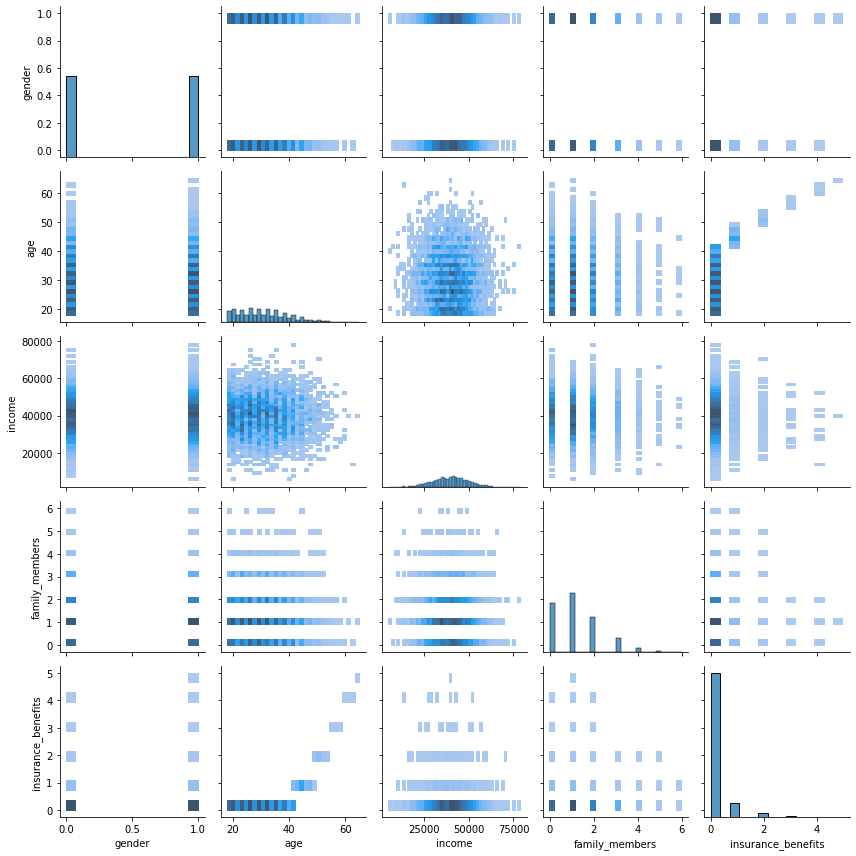

In [84]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Objetivo 1: Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribimos una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no se tomó en cuenta el número de prestaciones de seguro recibidas.

se probó el modelo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados.
  - los datos se escalan con el escalador (MaxAbsScaler).
  
    - Métricas de distancia
      - Euclidiana
      - Manhattan


In [85]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [86]:
def get_knn(df, n, k, metric= 'euclidean'):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    :param n: número de objetos para los que se buscan los vecinos más cercanos    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = NearestNeighbors(n_neighbors=k, metric= metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

## Escalamiento de datos

In [87]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [88]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
4583,0.0,0.461538,0.558228,0.500000,0
3654,1.0,0.292308,0.569620,0.166667,0
2120,1.0,0.323077,0.508861,0.166667,0
3942,1.0,0.307692,0.579747,0.000000,0
1346,0.0,0.400000,0.448101,0.166667,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [89]:
# Verifiacomos el funcionamiento de la función
get_knn(df_scaled, 25, 4, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
25,1.0,0.723077,0.486076,0.5,1,0.000000
954,1.0,0.707692,0.508861,0.5,1,0.027492
2491,1.0,0.676923,0.482278,0.5,1,0.046310
936,1.0,0.692308,0.435443,0.5,1,0.059249


**Afectación del uso de escalado de datos para el algoritmo de nearest neighbors**

In [90]:
# Definnimos los índices a evaluar, seleccionaremos 10 indices aleatoreos de ambos conjuntos de datos.
indexes = df.sample(10).index
indexes

Int64Index([509, 640, 211, 3692, 747, 2992, 836, 1579, 2582, 3022], dtype='int64')

In [91]:
# Obotenemos la distacia media de cada elemento evaluado en el conjunto de datos sin aplicar el escalado.
for index in indexes:
    print(get_knn(df, index, 10, 'euclidean')['distance'].mean())

120.43357122183156
10.196019149510452
1.8707406513449016
7.503665563623443
1.5414886022385912
7.889039254459125
24.69571372957455
15.250896699044414
5.792174911788062
20.63791795891292


In [92]:
# Observamos la distancia del primer elemento evaluado vs el vecino mas cercano
df.loc[[indexes[0],get_knn(df, indexes[0], 2,'euclidean').iloc[1].name]]

,gender,age,income,family_members,insurance_benefits
509,0,29,20200.0,0,0
1880,1,27,20200.0,2,0


In [93]:
distance.euclidean(df.loc[indexes[0]].values, df.loc[get_knn(df, indexes[0], 2,'euclidean').iloc[1].name].values)

3.0

In [94]:
# Almacenamos los indices mas cercanos de nuestro conjunto de datos escalado.
nneighbors_dict = {}
for index in indexes:
    nneighbors_dict[index] = get_knn(df_scaled, index, 10, 'euclidean').index
  

In [95]:
pd.DataFrame(nneighbors_dict)

,509,640,211,3692,747,2992,836,1579,2582,3022
0,509,640,211,3692,747,2992,836,1579,2582,3022
1,2,127,3200,4273,1928,1400,1832,4178,4273,2455
2,2031,4939,2596,2582,1698,1489,3072,2928,3692,199
3,224,4034,3085,3412,3200,3790,4827,1860,3841,2229
4,2838,3453,2922,3841,3280,4378,2746,1130,660,2622
5,648,4607,315,3710,698,2942,2580,3822,938,4038
6,4905,291,410,3020,571,4440,1869,1021,3412,2168
7,2857,1355,1698,660,4302,2150,824,815,755,4069
8,2067,3355,2619,938,216,4135,3779,3327,3424,3427
9,3156,1743,1243,4703,4951,4503,393,547,4770,290


In [96]:
# Observamos la distancia del primer elemento evaluado vs el vecino mas cercano según el conjunto de datos escalado.
df.loc[[indexes[0],get_knn(df_scaled, indexes[0], 2,'euclidean').iloc[1].name]]

,gender,age,income,family_members,insurance_benefits
509,0,29,20200.0,0,0
2,0,29,21000.0,0,0


In [97]:
distance.euclidean(df.loc[indexes[0]].values, df.loc[get_knn(df_scaled, indexes[0], 2,'euclidean').iloc[1].name].values)

800.0

In [98]:
# Obtenemos la distancia promedio de los indices evaludos con los vecinos mas cercanos utilizando el conjunto escalado.
distances = []
for index, value in nneighbors_dict.items():
    distances.append([distance.euclidean(df.loc[index], df.loc[index_v]) for index_v in value])

distances = np.array(distances)
distances_df = pd.DataFrame(np.transpose(distances), columns= nneighbors_dict.keys())
distances_df.mean()

509     1510.002296
640     1230.000289
211      420.101905
3692     990.000643
747      360.100484
2992     920.001402
836     1860.100153
1579    1860.001073
2582    1070.000310
3022    1410.000743
dtype: float64

**Diferencia al utilizar distancia euclidiana y cityblock en nearest neighbors**

In [99]:
#Obtenemos en un diccionario los índices mas cercanos utilizando distancia euclidiana.
euclidean_index = {}
for index in indexes:
    euclidean_index[index] = get_knn(df, index, 10, 'euclidean')['distance'].index
    
pd.DataFrame(euclidean_index)

,509,640,211,3692,747,2992,836,1579,2582,3022
0,509,640,211,3692,1928,2992,836,1579,2582,3022
1,1880,4060,2596,61,747,4448,1832,1285,4140,2779
2,4454,793,2470,4319,3280,944,1293,1274,2276,3244
3,4743,1101,1537,784,4534,2077,4382,3536,2462,4921
4,3812,3608,2827,4328,548,1665,632,4757,2532,1310
5,3725,67,162,3383,549,4260,2653,1460,1462,3951
6,419,861,1349,244,2389,236,1188,1550,3358,1950
7,3340,572,278,4363,240,1180,2100,3640,3843,2869
8,1200,3436,709,2435,980,1787,1150,3514,237,361
9,4866,3674,3533,3314,3693,1294,3769,1548,4190,1972


In [100]:
#Obtenemos en un diccionario los índices mas cercanos utilizando distancia cityblock.
cityblock_index = {}
for index in indexes:
    cityblock_index[index] = get_knn(df, index, 10, 'cityblock')['distance'].index
    
pd.DataFrame(cityblock_index)

,509,640,211,3692,747,2992,836,1579,2582,3022
0,509,640,211,3692,1928,2992,836,1579,2582,3022
1,1880,4060,2596,61,747,4448,1832,1285,4140,2779
2,4454,793,2470,4319,3280,944,1293,1274,2276,3244
3,4743,1101,1537,784,548,2077,4382,4757,2462,4921
4,3812,3608,1349,4328,549,1665,632,3536,1462,1310
5,3725,861,2827,3383,4534,236,2653,1460,3358,3951
6,419,67,278,2435,2389,4260,1188,1550,3843,1950
7,3340,572,162,244,240,1787,2100,3640,2532,2869
8,1200,3436,709,3314,3693,1180,1150,3514,237,361
9,4866,3674,3533,4363,980,1294,4969,1548,4408,1972


In [101]:
# Definimos una función para contabilizar las diferencias entre dos listas.
def get_dif_values(list_1, list_2):
    count = 0
    for item in list_1:
        if item not in list_2:
            count += 1
    return count

# Contabilizamos la cantidad de vecinos diferentes por cada observación evaluada.
count = []
for index in indexes:
    count.append(get_dif_values(euclidean_index[index], cityblock_index[index]))
    print(f'De las observaciones con indice {index} hay {get_dif_values(euclidean_index[index], cityblock_index[index])} vecinos diferentes')  
print('\n')
print(f'La cantidad de vecinos diferentes de la distancia euclidiana y cityblock es de {(sum(count)/pd.DataFrame(cityblock_index).values.size)*100} %')

De las observaciones con indice 509 hay 0 vecinos diferentes
De las observaciones con indice 640 hay 0 vecinos diferentes
De las observaciones con indice 211 hay 0 vecinos diferentes
De las observaciones con indice 3692 hay 0 vecinos diferentes
De las observaciones con indice 747 hay 0 vecinos diferentes
De las observaciones con indice 2992 hay 0 vecinos diferentes
De las observaciones con indice 836 hay 1 vecinos diferentes
De las observaciones con indice 1579 hay 0 vecinos diferentes
De las observaciones con indice 2582 hay 1 vecinos diferentes
De las observaciones con indice 3022 hay 0 vecinos diferentes


La cantidad de vecinos diferentes de la distancia euclidiana y cityblock es de 2.0 %


### Preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN?** 

Si afecta al algoritmo kNN, ya que si ingresamos como parámetro el conjunto de datos sin escalar intentará encontrar vecinos con el salario igual y luego las demás características, esto sucede porque la diferencia de salarios es muy alta con respecto a la diferencia de edades. 

Esto no pasa cuando el conjunto está escalado, ya que la diferncia de valores es igual, entonces no necesariamente toma un vecino con el salario igual, evalua todas las características de igual forma.

De mi punto de vista en el primer caso el algoritmo es muy estrícto en buscar salarios iguales, por lo que esto talvez ignora la cercanía con otras observacines basándose en otras características, otra forma de solucionar el problema es asignando escalas salariales numéricas para que el algoritmo pueda evaluar las observacions de una forma mas ponderada.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Para responder esta pregunta contabilizamos cuantos vecinos son diferentes del resultado del algoritmo kNN evaluados con la distancia euclideana y cityblosk. En 10 observaciones evaluadas con 10 vecinos cercanos nos dió un total de 2 vecinos difentes del total de 100, esto nos indica que apenas el 2% de los índices vecinos son diferentes.

En conclusión ambas distancias devuelven resultados iguales.

# Objetivo 2 ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evaluamos si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.

- Construimos un clasificador basado en KNN y medimos su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. De esta manera observamos cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Utilizaremos una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

- Construimos un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probaremos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como:


$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$


In [102]:
# сalcula el objetivo
df['insurance_benefits_received'] = df['insurance_benefits'] > 0
df['insurance_benefits_received'] = df['insurance_benefits_received'].astype(int)

In [103]:
df.head(5)

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,0
1,0,46,38000.0,1,1,1
2,0,29,21000.0,0,0,0
3,0,21,41700.0,2,0,0
4,1,28,26100.0,0,0,0


In [104]:
# Comprobamos el desequilibrio de clases con value_counts()

df['insurance_benefits_received'].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

El conjunto de datos tiene un fuerte desequilibrio de clases.

In [105]:
# Definimos las características y el objetivo.
y = df['insurance_benefits_received']
X = df.drop(['insurance_benefits', 'insurance_benefits_received'], axis= 1)

print(y.shape)
print(X.shape)

(5000,)
(5000, 4)


In [106]:
# Definimos el grupo de prueba y el de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3,  random_state= 42)

X_train = X_train.reset_index(drop= True)
X_test = X_test.reset_index(drop= True)
y_train = y_train.reset_index(drop= True)
y_test = y_test.reset_index(drop= True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3500, 4)
(1500, 4)
(3500,)
(1500,)


In [107]:
# Escalamos los conjuntos de prueba y entrenamiento
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(X_train)

X_train_scaled = pd.DataFrame(transformer_mas.transform(X_train), columns= X_train.columns, index= X_train.index)
X_test_scaled = pd.DataFrame(transformer_mas.transform(X_test), columns= X_test.columns, index= X_test.index)

In [108]:
print(X_train_scaled.head())
print(X_test_scaled.head())

   gender       age    income  family_members
0     0.0  0.564516  0.458228        0.166667
1     0.0  0.419355  0.279747        0.166667
2     0.0  0.306452  0.551899        0.166667
3     0.0  0.661290  0.392405        0.500000
4     1.0  0.500000  0.470886        0.166667
   gender       age    income  family_members
0     1.0  0.451613  0.710127        0.000000
1     1.0  0.516129  0.530380        0.333333
2     1.0  0.483871  0.332911        0.000000
3     1.0  0.483871  0.472152        0.333333
4     0.0  0.709677  0.379747        0.166667


In [109]:
# Definimos una función para obtener el valor F1 y la matriz de confusión.
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
        
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
   
    return f1_score, cm

**Obtenemos resultados utilizando nuestro modelo KNN para el conjunto sin escalar.**

In [110]:
# Realizamos predicciones con nuestro modelo para el conjunto de datos sin escalar.
results_nonscaled = []
for k in range(10):
    
    knn_model = KNeighborsClassifier(n_neighbors= k+1)
    knn_model.fit(X_train, y_train)
    predictions = knn_model.predict(X_test)
    
    results_nonscaled.append(eval_classifier(y_test, predictions)[0])

**Obtenemos resultados utilizando nuestro modelo KNN para el conjunto escalado.**

In [111]:
# Realizamos predicciones con nuestro modelo para el conjunto de datos escalado.
results_scaled = []
for k in range(10):
    
    knn_model = KNeighborsClassifier(n_neighbors= k+1)
    knn_model.fit(X_train_scaled, y_train)
    predictions = knn_model.predict(X_test_scaled)
    
    results_scaled.append(eval_classifier(y_test, predictions)[0])

**Observamos como f1 varía con el número de vecinos K y con el conjunto escalado y no escalado**

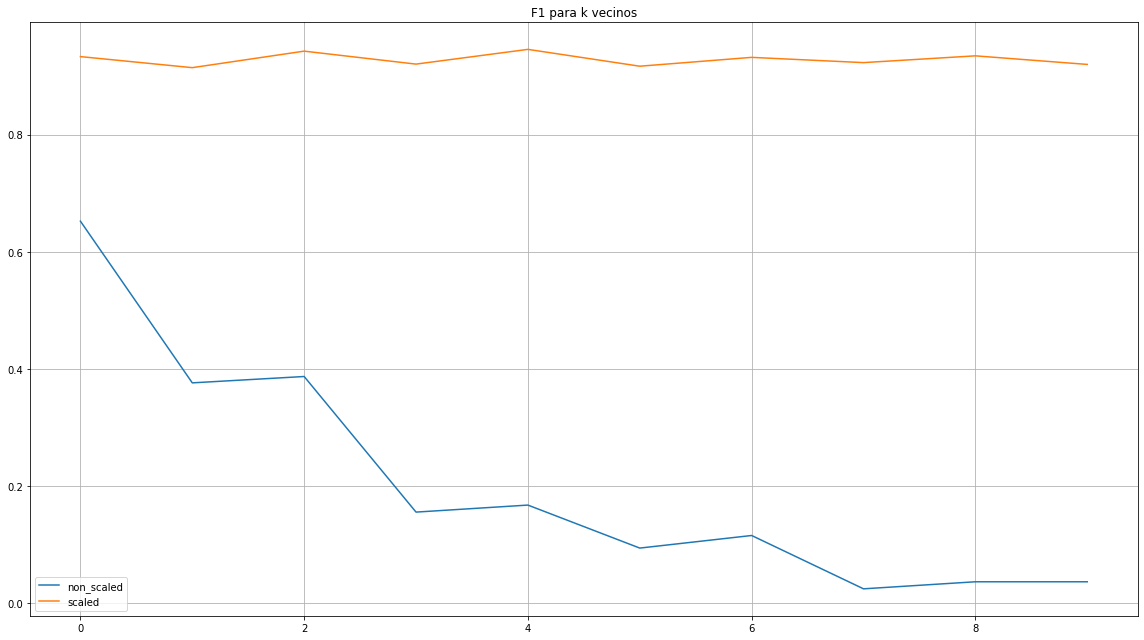

In [112]:
results = pd.DataFrame()
results['non_scaled'] = results_nonscaled
results['scaled'] = results_scaled
results.plot(kind= 'line', grid= True, figsize= (16,9), title= 'F1 para k vecinos')
plt.show()

In [113]:
# Generamos la salida de un modelo aleatorio binomial ingresando la probabilidad como parámetro.

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [114]:
print(rnd_model_predict(0.5,10))

[1 0 1 1 0 1 1 1 0 0]


In [115]:
# Probamos con diferentes probabilidades y evaluamos.
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}\n')
    y_pred_rnd = rnd_model_predict(P, df.shape[0]) 
    
    result = eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    print(f'F1: {result[0]} \nMatriz de confusión:\n {result[1]}')
    
    print()

La probabilidad: 0.00

F1: 0.0 
Matriz de confusión:
 [[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11

F1: 0.12072072072072074 
Matriz de confusión:
 [[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50

F1: 0.19807883405101026 
Matriz de confusión:
 [[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00

F1: 0.20273184759166066 
Matriz de confusión:
 [[0.     0.8872]
 [0.     0.1128]]



**Conclusiónes:**

- Podemos observar que para el conjunto escalado el valor F1 disminuye a medida que el número de vecinos aumenta, en otras palabras el conjunto de datos no escalado es susceptible a un diferente número de vecinos. Por otro lado el valor F1 para el conjunto escalado no varía a pesar de que el número de vecinos aumenta, además la métrica F1 es muy superior con el conjunto escalado.


- Un modelo aleatorio tiene muy mal desempeño y no puede superar los resultados de nuestro modelo KNN.



# Objetivo 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evaluamos cuál sería la RECM de un modelo de regresión lineal.

Construiremos nuestra propia implementación de regresión lineal y comprobaremos la RECM tanto para los datos originales como para los escalados. 

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos


$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Dividimos todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utilizamos la métrica RECM para evaluar el modelo.

In [116]:
# Definimos una clase para la regresión lineal
class MyLinearRegression:
    
    def fit(self, X, y):
        self.X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        self.y = y
        w = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(self.X),self.X)), np.transpose(self.X)) , y)
        self.w = w[1:]
        self.w0 = w[0]
        

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [117]:
# Definimos una función para evaluar el modelo
def eval_regressor(y_true, y_pred):
    
    try:
        rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
        print(f'RMSE: {rmse:.2f}')
    except:
        print('Valor 0 en el denominador')
    try:
        r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
        print(f'R2: {r2_score:.2f}')
    except:
        print('Valor 0 en el denominador')

In [118]:
# Generamos predicciones con nuestro modelo y conjunto de datos no escalado
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.w)

y_test_pred = lr.predict(X_test)
#pd.DataFrame(y_test_pred).hist(bins= 50)
eval_regressor(y_test, y_test_pred)

[ 3.57495491e-02  1.64272726e-02 -2.60743659e-07 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [119]:
# Generamos predicciones con nuestro modelo y conjunto de datos escalado
lr = MyLinearRegression()

lr.fit(X_train_scaled, y_train)

y_test_pred = lr.predict(X_test_scaled)

eval_regressor(y_test, y_test_pred)


[ 0.00573967 -0.06188421  0.1017913   0.05817647]
RMSE: 0.46
Valor 0 en el denominador


# Objetivo 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas.

$$
X' = X \times P
$$

Ofuscaremos los datos y luego vamos a visualizar cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que nos aseguramos de que $P$ sea realmente invertible.

In [120]:
# Seleccionamos las variables a proteger.
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [121]:
# Transformamos nuestro conjunto en vectores
X = df_pn.values
X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

Generar una matriz aleatoria $P$.

In [122]:
# Generamos una matriz P aleatoria de las mismo número de filas y columnas que nuestro conjunto de datos.
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobamos que la matriz P sea invertible.

In [123]:
# Para demostrar que una matriz es invertible la multiplicación de la matriz por su inversa debe ser una matriz indentidad.

print(P.dot(np.linalg.inv(P)).round(14))

[[ 1. -0. -0. -0.]
 [-0.  1. -0.  0.]
 [-0. -0.  1.  0.]
 [-0. -0.  0.  1.]]


Ya que la diagonal son todos 1 y los demás valores muy cercanos a 0, se puede decir que si es invertible.

¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

**Es imposible adivinar la edad o los ingresos después de aplicar la transformación.**

In [124]:
# Ofuscamos el conjunto de datos con la matriz P realizando una multiplicación escalar
X_ofus = X.dot(P)

In [125]:
X_ofus

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Se puede recuperar los datos originales de $X'$ siempre y cuando conozcamos $P$ 

**Si es posible recuperar los datos de conociendo el valor P, solo hay que multiplicarlo por su inversa**

In [126]:
# Multiplicamos nuestra matriz ofuscada por la matriz p invertida.
X_ofus.dot(np.linalg.inv(P))

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-4.47363596e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-2.51586878e-12,  2.90000000e+01,  2.10000000e+04,
         9.52452315e-13],
       ...,
       [-1.92837871e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Muestramostres casos para algunos clientes- Datos originales


In [127]:
# Índices a evaluar.
indices = [25, 45, 264]

# Conjunto original 
df_pn.loc[indices]

,gender,age,income,family_members
25,1,47,38400.0,3
45,0,24,30400.0,1
264,1,46,46500.0,1


In [128]:
# Conjunto transformado
pd.DataFrame(X_ofus, columns= df_pn.columns).loc[indices]

,gender,age,income,family_members
25,4926.695382,17343.581429,14276.606537,35626.099678
45,3897.558555,13715.970210,11290.970704,28192.748443
264,5963.033899,20989.086380,17278.422565,43131.655546


In [129]:
# Conjunto recuperado de la transformación
pd.DataFrame(X_ofus.dot(np.linalg.inv(P)), columns= df_pn.columns).loc[indices].round().abs().astype(int)

,gender,age,income,family_members
25,1,47,38400,3
45,0,24,30400,1
264,1,46,46500,1


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

**Se puede observar que algunos valores no son exactamente iguales a los datos originales esto se debe a la precisión de punto flotanta inherente al procesador de las PC's, ya que esta precisión no es infinita redondea los valores, por este motivo no podemos obtener una matriz identidad exacta con valores igual a 0, por este motivo al recuperar los datos del conjunto de datos original, los valores 0 son valores muy pequeños los cuales son cercanos a 0 y se los considera como 0.**

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Ahora vamos a demostrarlo analiticamente que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos.

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como


$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$



**Respuesta**

$$
wp = P^{-1} w
$$

**Prueba analítica**

$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

Aplicamos Reversibilidad de la transposición de un producto de matrices

$$
w = X^{-1} (X^T)^{-1} X^T y \quad \Rightarrow \quad w_p = [(P^T X^T)(X P)]^{-1} P^T X^T y
$$

Agrupamos

$$
w_p = [P^TX^T XP]^{-1} XP^TX^T y = [P^T(X^T XP)]^{-1} P^TX^T y
$$

Aplicamos la ley de identidad.

$$
w_p = (X^T XP)^{-1} (P^T)^{-1} P^TX^T y
$$

Agrupamos el primer término.

$$
w_p = ((X^T X)(P))^{-1} (P^T)^{-1} P^TX^T y
$$

Volvemos a aplicar la ley de identidad al primer término.

$$
w_p =  (P)^{-1}(X^T X)^{-1} (P^T)^{-1} P^TX^T y
$$

Reemplazamos por la matriz identidad

$$
w_p =  (P)^{-1}(X^T X)^{-1} IX^T y
$$

Que es lo mismo 

$$
w_p =  (P)^{-1}(X^T X)^{-1} X^T y
$$

Aplicamos la ley de identidad al segundo término.



Ya que $$w = (X^TX)^{-1} X^T y$$ entonces $$wp = P^{-1} w$$  


## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Vamos a construir un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación.

**Procedimiento**

  - Creamos una matriz cuadrada $P$ de números aleatorios y verificamos que sea invertible. Si no lo es se repite el primer paso hasta obtener una matriz invertible.
    
        
       
  - Utilizamos $XP$ como la nueva matriz de características

In [130]:
class MyLinearRegression:
    
    def fit(self, X, y, P=None):
        
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        y = y
        w = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X),X)), np.transpose(X)) , y)
        self.w = w[1:]    
        if P is not None:
            
            self.w= np.dot(np.linalg.inv(P), self.w)
                
        
        self.w0 = w[0]    
  
            

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [131]:
# Definimos una función para evaluar el modelo
def eval_regressor(y_true, y_pred):
    
    try:
        rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
        print(f'RMSE: {rmse:.2f}')
    except:
        print('Valor 0 en el denominador')
    try:
        r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
        print(f'R2: {r2_score:.2f}')
    except:
        print('Valor 0 en el denominador')

In [132]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Dividimos nuestro conjunto en prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr = MyLinearRegression()

lr.fit(X_train, y_train)


y_test_pred = lr.predict(X_test)

eval_regressor(y_test, y_test_pred)

RMSE: 0.36
R2: 0.65


In [133]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Dividimos nuestro conjunto en prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Generamos una matriz P para ofuscar
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

# Ofuscamos X
X_train = np.dot(X_train, P)

lr = MyLinearRegression()

# Pasamos P como parámetro ya que nos servirá para recuperar X
lr.fit(X_train, y_train, P)
print(lr.w)

y_test_pred = lr.predict(X_test)

eval_regressor(y_test, y_test_pred)

[ 0.11918387 -0.01575267 -0.23215069  0.16161971]
RMSE: 9543.14
Valor 0 en el denominador


# Conclusiones

- El algoritmo de KNN funciona bastante bien para encontrar observaciones similares, además escalar los datos nos ayudrá a encontrar vecinos cercanos en base a otras características ya que iguale los pesos en distancias.


- El algoritmo de KNN funcionó bastante bien al momento de predecir nuestro objetivo 'insurance_benefits_recived', el cual era un problema de clasificación. Y entregó mejores resultados para el conjunto de datos escalado.


- La regresión lineal aplicada a la predicción de nuestros objetivo 'insurance_benefits' nos dió buenos resultados para RMSE y R2, lastimosamente para los datos escalados tuvimos un error de valor 0 en el denominador.


- Ofuscar los datos es una herramiento muy útil para proteger información sensible, pero no funciona para realizar el modelo de regresión lineal ya que obtenemos métricas muy distintas.
